# Module 08: Model Calibration
## Using Calibration Algorithms

In the notebook we previously reviewed (see here: [mod08-Snow17-SA.ipynb](mod08-Snow17-SA.ipynb)), we explored model calibration via what we called a "brute force" method. "Brute force" calibration usually looks something like: 

1. Creating a large sample of parameter combinations to consider that span the feasible space of our parameters,
2. Run the model for each parameter combination and compute some measure of model performance in simulating some observed property. In our case we examined modeled versus observed Snow Water Equivalent via six different performance measured: bias, root mean squared error (RMSE), mean absolute error (MAE), Pearson correlation coefficient ($\rho$), Kling Gupta Efficiency (KGE) index, and Nash Sutcliffe Efficiency (NSE) index,
3. Create a visualization of how the "surface" of one or more of these performance measures vary over the feasible parameter space, and
4. Choose one or more sets of parameters that are in regions of reasonably "good" model performance. 

This approach has some important benefits:

* It allows us to visualize how one or more of the performance metrics varies over our feasible parameter space, allowing us to assess whether there is a broad range of parameters that produce reasonable results, whether there are multiple maxima/minima for different parameter combinations, or whether there's a relatively small region of parameters associated with "good" performance.
* It allos us to leave no stone uncovered, examining combinations of parameters that are potentially unlikely based on prior knowledge, but which may nevertheless produce reasonable model predictions.
* It is straightforward. It just requires some knowledge about how to create combinations of parameters and run the model as many times as needed to cover the entirety of the feasible parameter space. 

The brute force approach to calibration is also not without its drawbacks. In particular:

* This approach spends a lot of time on model simulations that are not likely to yield reasonable results. In that way it can be wasteful of computational resources (and the energy needed to use them).
* For relatively simple models like the Snow-17 model we're using, it is relatively cheap. But for more sophisticated models with more parameters or more complex equations being solved – or for models that are explicitly resolving spatiotemporal behavior – it may be infeasibly computationally expensive to use.  
* Even intuitively, there are better approaches that are more efficient. For example, a very naive approach to a more efficient calibration algorithm might: (1) take an initial guess of parameters, run the mode, and compute a performance measure, (2) make a small random perturbation the initial guess parameters, run the model again, and compute the performance measure for the candidate parameters, (3) accept/reject these new parameters if the performance measure is better/worse, and (4) repeat until we get to a place where $N$ successive perturbations doesn't lead to better model performance.

In this notebook, we will compare more elegant/sophisticated ways of calibrating our model parameters. These approaches, known as __*optimization algorithms*__, use the performance measures we computed in the previous notebook (e.g., MAE, RMSE) as "objective functions" that are to be minimized. Using these optimization algorithms is equivalent to telling the computer to __go walk around the parameter space until you find a set of parameters that minimizes the RMSE__. But it's even better than that, because we will have control over:

1. __*How*__ the algorithm walks through the parameter space (the optimization method), and
2. __*What*__ objective function the algorithm is minimizing.

__Discussion Prompt__: To get an intuitive sense of how these optimization approaches a reasonably good analogy is to think about a scenario in which you are placed – blindfolded – into the middle of a topographic landscape and asked to find the valley bottom in as few steps as possible. The topographic elevation represents which objective function you're using. The rules with which you navigate that topographic surface – blindfolded – represent the details of the optimization algorithm.   

Below we will use a specific optimization method (the so-called conjugate gradient method) and explore two different objective functions – the KGE and RMSE - to calibrate our Snow-17 model parameters, $D_D$ and $T_t$.

### 1. Notebook Setup
We will be using the `scipy.optimize` and `matplotlib.animation` libraries, which are new to us. The `scipy.optimize` library provides us a powerful set of tools to optimize our model. The `matplotlib.animation` tools are going to allow us to create a visualization of how the optimization algorithms navigated the "surface" of our objective function. 

It's important to note that the previous notebook we reviewed, saved as output the computed error metrics for all parameter combinations and saved them in a file called `Snow17_sensitivity_analysis.csv`. In most model calibration scenarios we would not have this information. But because we saved it, we effectively have the "topographic map" that the optimization algorithm was navigating. This allows us to watch how the algorithm worked and perhaps identify some shortcomings of either the optimization method or the objective function we used. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import numbers
from matplotlib.animation import FuncAnimation

# The name of file that contains forcing and observed SWE during every day of water year 2001-2020
forcing_fname = 'EastRiver_hydro_data_2001-2020.csv'

# The name of the file containing parameter combinations and associated KGE values from our
# sensitivity analysis
saved_error_metric_values_fname = 'Snow17_sensitivity_analysis.csv'

date_beg = '2000-10-01' # This is the first day of water year 2016
date_end = '2020-09-30' # This is the last day of water year 2020

DD_i = 5.0 # Initial guess for degree-day factor
Tt_i = 0.0 # Initial guess for temperature threshold

DD_lower = 1.0  # Lower bound for degree-day factor
DD_upper = 10.5 # Upper bound for degree-day factor
Tt_lower = -1.0 # Lower bound for temperature threshold
Tt_upper = 7.0  # Upper bound for temperature threshold


## 2. Define Model and Error Metrics
### 2.1 Define the Snow17 Model

Below we are again defining the Snow-17 as a function to which we can pass as input the time series of daily average air temperature (`Ta`) and daily total precipitation (`P`), as well as the parameters `DD` and `Tt`, and which will provide outputs of simulated daily SWE (`SWE_s17`), simulated daily snowmelt (`Sm_s17`), and simulated daily total liquid precipitation (`Pliq_s17`). Again, in this notebook we won't be doing anything with the latter two outputs.

In [2]:
def Snow17(Ta,P,DD,Tt):
    
    assert Ta.shape == P.shape, 'Precipitation and Temperature vectors must have the same shape'
    assert isinstance(DD, numbers.Number), 'Degree day coefficient must be a scalar'
    assert isinstance(Tt, numbers.Number), 'Temperature threshold must be a scalar'

    Nt = np.max(Ta.shape)
    
    SWE_s17 = np.zeros(Ta.shape)
    Sm_s17 = np.zeros(Ta.shape)
    Pliq_s17 = np.zeros(Ta.shape)
    
    for i in np.arange(Nt):

        P_i  = P[i] # The value of precipitation on this date
        Ta_i = Ta[i] # The value of average air temperature on this date

        # Initial conditions: we are starting when there should not be any appreciable snow in the watershed, 
        # so we will assume that SWE = 0. If you decide to run another date when there might be snow (e.g., Jan. 1)
        # then you would need a more realistic value of SWE.
        if(i==0):
            SWE_i = 0.0 
        else:
            SWE_i = SWE_s17[i-1] # The initial SWE on these dates is simply the SWE from the day before. We will add snow or subtract melt.
            
        # If SWE is greater than zero, there *may* be snowmelt
        if(SWE_i>0.0):
            if(Ta_i>Tt): # If the air temperature is greater than the threshold, there **will** be melt
                Sm_i = DD*(Ta_i-Tt) # Snowmelt via degree-day factor
            else: # If the air temperature is below the threshold, there is no melt
                Sm_i = 0.0 # No snowmelt if temperature does not exceed threshold
        else: # If there is no SWE, by definition there is no snowmelt
            Sm_i = 0.0
        
        # If there is precipitation, figure out its phase
        if((P_i>0.0) and (Ta_i<=Tt)):
            SWE_i += P_i # All precip will be added to SWE storage
            Pliq_i = 0.0 # There is no liquid precipitation
        elif((P_i>0.0) and (Ta_i>Tt)):
            Pliq_i = P_i # All precipitation falls as liquid. NOTE: We are assuming rain does not melt snow!!!
        else: # If there is no precipitation, there is nothing to accumulate
            Pliq_i = 0.0
        
        SWE_s17[i] = np.max([SWE_i - Sm_i,0.0]) # Make sure we can only melt as much SWE as there is. This only matters at low SWE
        Sm_s17[i] = Sm_i # Save the snowmelt... QUESTION: Is this something we can observe?!?!?!?!
        Pliq_s17[i] = Pliq_i
        
        
    return SWE_s17, Sm_s17, Pliq_s17

### 2.2 Define the Kling Gupta Efficiency

One of the objective functions we will be using will rely on the Kling Gupta Efficiency (KGE) index. The following function computes KGE as a function of an input time series of modeled (`y_m`) and observed (`y_o`) values. Note that in this notebook we will be exclusively passing simulated and observed SWE to compute the KGE, but this code is written generally so any two vectors of simulated and observed values could be passed. 

In [3]:
def KlingGuptaEfficiency(y_m,y_o):
    
    # Inputs: 
    # y_m: Modeled time series
    # y_o: Observed time series
    
    # 2. Compute KGE
    # 2a. Get correlation coefficient 
    df_y = pd.DataFrame({'y_m': y_m, 'y_o': y_o})
    rho_mat = df_y.corr().values
    rho = rho_mat[1,0]
    
    # 2b. Get normalized mean 
    beta = np.nanmean(y_m) / np.nanmean(y_o)
     
    # 2c. Get normalized standard deviation
    alpha = np.nanstd(y_m) / np.nanmean(y_o)
    
    # 2d. Compute KGE 
    KGE = 1.0 - np.sqrt((rho - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    
    return KGE

### 2.3 Define the Root Mean Squared Error

Similarly, we will also use an objective function that seeks to minimize the RMSE. The code below takes an input time series of modeled (`y_m`) and observed (`y_o`) values and returns the RMSE between them. Again, we will exclusively be using modeled and observed SWE in this notebook, but the function is written to generally take any time series of modeled and simulated values.  

In [4]:
def RMSE(y_m,y_o):
    
    # Inputs: 
    # y_m: Modeled time series
    # y_o: Observed time series
    
    RMSE = np.sqrt(np.nanmean((y_m - y_o)**2))
    
    return RMSE

## 3. Read in the Forcing Data and Observed SWE

In [5]:
# Read in the forcing data data
df_forcing = pd.read_csv(forcing_fname)

# Reindex to create make sure that the index for the dataframe is a datetime64 object
df_forcing['Date'] = pd.to_datetime(df_forcing['Date'],format='%Y-%m-%d')
df_forcing.index = df_forcing['Date']

ForcingDates = df_forcing[date_beg:date_end]['Date'].values
P_exp = df_forcing[date_beg:date_end]['pcp'].values
Ta_exp = df_forcing[date_beg:date_end]['tair'].values
SWE_o = df_forcing[date_beg:date_end]['SWE'].values

t = pd.date_range(start=date_beg, end=date_end, freq='1D')

# Here's what a pandas "dataframe" looks like:
df_forcing

,Date,tair,pcp,Q,SWE,PET
Date,,,,,,
2000-10-01,2000-10-01,10.555556,0.00,0.356384,NaN,4.960398
2000-10-02,2000-10-02,10.555556,0.00,0.334212,NaN,4.924742
2000-10-03,2000-10-03,8.333333,0.00,0.332784,NaN,4.243824
2000-10-04,2000-10-04,2.777778,7.62,0.327819,NaN,2.923413
2000-10-05,2000-10-05,4.444444,0.00,0.370463,NaN,3.244371
...,...,...,...,...,...,...
2020-09-26,2020-09-26,12.777778,0.00,0.228555,0.0,5.908478
2020-09-27,2020-09-27,9.444444,0.00,0.230085,0.0,4.757537
2020-09-28,2020-09-28,4.444444,0.00,0.230415,0.0,3.412351


## 4. Optimize on KGE

Below we define an objective function for the KGE metric. Recall that the definition of KGE is such that an optimal value of KGE = 1, which is also a maximum. Because the `scipy.optimize` code is written in a way that requires minimization of an objective function, maximizing KGE is equivalent to minimizing -KGE. As such, we want our optimization algorithm to find the values of $D_D$ and $T_t$ that get as close to -KGE = -1 as possible.

### 4.1 Define the KGE Objective Function

The code below defines the objective function we will optimize on, taking the input `params` which contain the trial values of $D_D$ and $T_t$, and returning the value of -KGE. The code takes the parameters as input, uses those parameters and the previously defined forcings (`Ta` and `P`) to simulate SWE, calls the previously defined function to compute the Kling Gupta Efficiency index based on the modeled (`SWE_m`) and observed (`SWE_o`) snow water equivalent, and returns -KGE. 


In [6]:
def objective_function_kge(params):
    DD_exp, Tt_exp = params # Get the DD and Tt parameters
    
    # 1. Call Snow-17 model 
    SWE_m, Sm_m, Pliq_m = Snow17(Ta_exp,P_exp,DD_exp,Tt_exp) # Note: Ta_exp and P_exp were defined previously and therefore don't need to be passed as input
    
    # 2. Get KGE value for simulated SWE
    KGE_exp = KlingGuptaEfficiency(SWE_m,SWE_o)

    # 3. Return -KGE because the optimization function we're using seeks minimization
    return -KGE_exp
    

The following creates a list and a function in which we will store __all__ intermediate guesses from the optimization algorithm. This is not strictly necessary, but we will use these intermediate guesses to create a cool animation of how the optimization algorithm navigated the KGE surface. 

In [7]:
intermediate_guesses_list = []

def callback(params):
    intermediate_guesses_list.append(params.copy())

### 4.2 Call Optimization Code

We package together the initial guess that we defined at the top of the notebook, and then call the `optimize.minimize()` function. We're specifying a couple of options here (don't worry too much about that), but what's important to note here is that we're using a so-called conjugate gradient method (note below that `method='CG'`). You can think of this method as a way that specifies how the optimization algorithm searches for and moves in the direction of decreasing -KGE. Specifically, how does it compute the direction of steepest descent in -KGE and how big of a step size does it take in that direction.  

In [8]:
initial_guess = [DD_i, Tt_i]

optimized_params = optimize.minimize(
    objective_function_kge,
    initial_guess, 
    callback=callback, 
    method='CG',
    jac='2-point',
    options={
        'disp': True,
        'maxiter': 1000,
    }
    )

# Create a numpy array of the intermediate guesses
intermediate_guesses = np.array(intermediate_guesses_list)

# Print the optimized parameters to the screen
print("Optimized Parameters:", optimized_params.x)


         Current function value: -0.838914
         Iterations: 7
         Function evaluations: 331
         Gradient evaluations: 110
Optimized Parameters: [1.28558212 0.69071302]


/Users/lejoflores/miniconda3/envs/geos505/lib/python3.11/site-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


### 4.3 Compute and Plot SWE with Optimized `DD` and `Tt` 

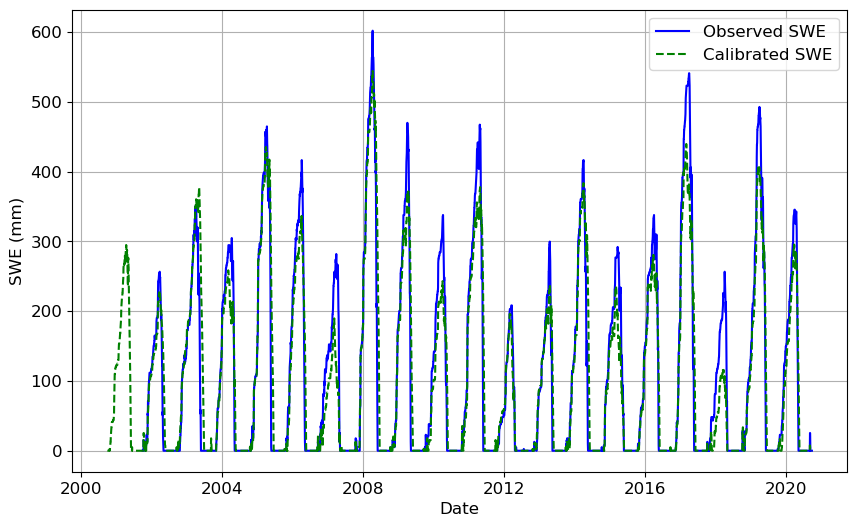

In [9]:
# Retrieve the optimized parameters for optimization on KGE
optimized_DD = optimized_params.x[0]
optimized_Tt = optimized_params.x[1]

# Use optimized parameters to compute the modeled SWE
calibrated_SWE, clibrates_Sm, calibrated_Pliq = Snow17(Ta_exp, P_exp, optimized_DD, optimized_Tt)

# Plot the modeled and observed SWE
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10, 6))
plt.plot(t, SWE_o, label="Observed SWE", color="blue")
plt.plot(t, calibrated_SWE, label="Calibrated SWE", color="green", linestyle="--")
plt.xlabel("Date")
plt.ylabel("SWE (mm)")
plt.legend()
plt.grid()
plt.show()


### 4.4 Create and Animation of the Optimization Path

The code below creates a cool visualization that illustrates what path the optimizaation algorithm took from the initial guess that we provided it to the final optimized values that it found. 

Note, ordinarily in most optimization problems we won't have this animation because we usually don't know what the objective function surface looks like. We are taking advantage of the fact that we ran some 500 simulations with different parameter combinations in a previous notebook and that we computed KGE (and other error metrics) for each of those simulationss and produced a contour map of what that surface looks like. 

This code creates an animated GIF file that is then displayed below and which you can also see by clicking [downhill_simplex_kge_optimization.gif](./downhill_simplex_kge_optimization.gif) file.

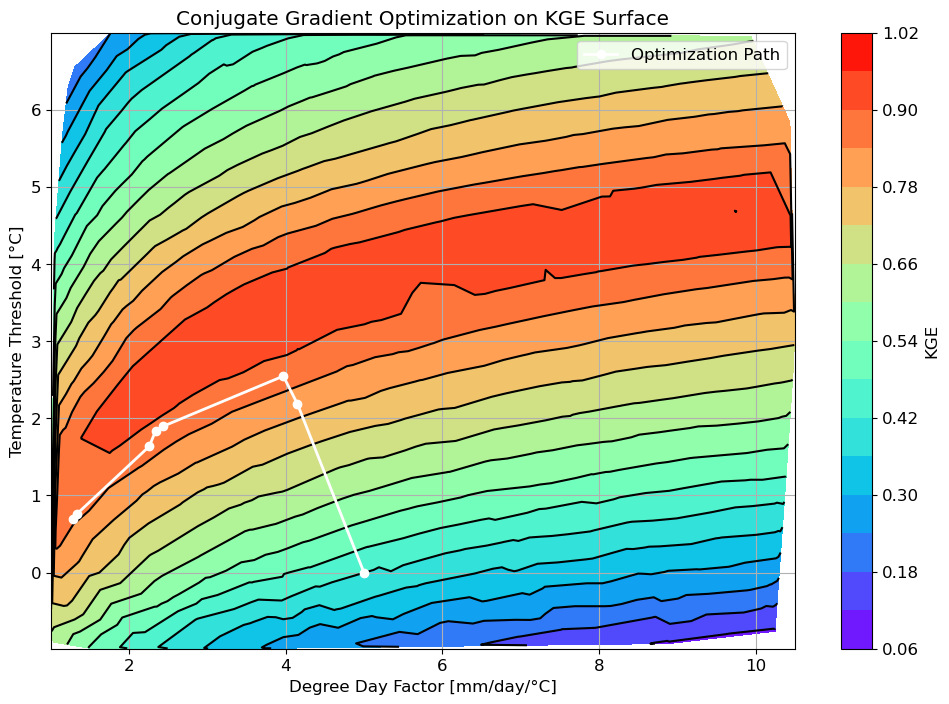

In [10]:
df_error_metric_sa = pd.read_csv(saved_error_metric_values_fname)

DD_sa = df_error_metric_sa['DD_sa'].values
Tt_sa = df_error_metric_sa['Tt_sa'].values
KGE_sa = df_error_metric_sa['KGE_sa'].values

# Create a figure for the animation
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the KGE surface
contour = ax.tricontour(DD_sa,Tt_sa,KGE_sa,levels=15,colors='k')
contourf = ax.tricontourf(DD_sa,Tt_sa,KGE_sa,levels=15,cmap='rainbow')
cbar = plt.colorbar(contourf, ax=ax)
cbar.set_label("KGE")

# Add labels
plt.xlabel('Degree Day Factor [mm/day/°C]')
plt.ylabel('Temperature Threshold [°C]')
plt.grid('on')
ax.set_title('Conjugate Gradient Optimization on KGE Surface')

intermediate_guesses = np.vstack((initial_guess, intermediate_guesses))

# Plot the optimization path as an animation
line, = ax.plot([], [], '-o', color='white', label='Optimization Path', lw=2)
ax.legend()

# Initialize the animation
def init():
    line.set_data([], [])
    return line,

# Update function for each frame
def update(frame):
    # Plot the path up to the current frame
    line.set_data(intermediate_guesses[:frame+1, 0], intermediate_guesses[:frame+1, 1])
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(intermediate_guesses), init_func=init, blit=True, interval=500)

# Save or display the animation
ani.save('downhill_simplex_kge_optimization.gif', writer='pillow', fps=2)  # Save as GIF

![Conjugate Gradient Optimization on KGE](./downhill_simplex_kge_optimization.gif)

What do you note about this optimization path? Does it get where we think it should based on our visualization of the KGE surface? 

## 5. Using an Alternative Objective Function

Now we want to ask if we would get a similar or different answer if we chose a different objective function to optimize on? Let's try the same thing again, but this time using RMSE as the objective function instead of KGE.

Again, below we define an objective function for `optimize.minimize()`, but instead of optimizing on KGE, we will instead find the optimal values of `DD` and `Tt` that minimize RMSE. The objective function code below, therefore: (1) gets the trial parameters input from the calling function, (2) passess those parameters and the previously defined `Ta` and `P` to the `Snow17()` function, which returns the modeled SWE (`SWE_m`), (3) passes `SWE_m` and the observed SWE (`SWE_o`) to the RMSE function and then returns the RMSE to the `optimize.minimize()` routine. 

In [11]:
def objective_function_rmse(params):
    DD_exp, Tt_exp = params # Get DD and Tt parameters
    
    # 1. Call Snow-17 model 
    SWE_m, Sm_m, Pliq_m = Snow17(Ta_exp,P_exp,DD_exp,Tt_exp)
    
    # 2. Get RMSE value for simulated SWE
    RMSE_exp = RMSE(SWE_m,SWE_o)

    # 3. Return RMSE because the optimization function we're using seeks minimization
    return RMSE_exp
    

### 5.1 Optimize Parameters on RMSE

The code below creates a list and function that allows us to store the intermediate values of our optimization path to create a visualization later. We then use the same initial guess that we used when optimizing on KGE, call the `optimize.minimize()` function with the same method (conjugate gradient method) and largely the same options (in this case we're using a 3-point Jacobian instead of a 2-point one... don't worry about this subtle detail).

Based on the optimized parameters, it then calculates the modeled SWE by calling the `Snow17()` function.

In [12]:
intermediate_guesses_list_rmse = []

def callback(params):
    intermediate_guesses_list_rmse.append(params.copy())
    
initial_guess = [DD_i, Tt_i]

optimized_params_rmse = optimize.minimize(
    objective_function_rmse,
    initial_guess, 
    callback=callback, 
    method='CG',
    jac='3-point',
    options={
        'disp': True,
        'maxiter': 2000,
    }
    )

# Get a numpy array of the intermediate guesses
intermediate_guesses_rmse = np.array(intermediate_guesses_list_rmse)

# Print the values of the optimized parameters to the screen
print("Optimized Parameters:", optimized_params_rmse.x)

# Get the optimized parameters and store them
optimized_DD_rmse = optimized_params_rmse.x[0]
optimized_Tt_rmse = optimized_params_rmse.x[1]

# Use optimized parameters to simulate SWE
calibrated_SWE_rmse, clibrates_Sm_rmse, calibrated_Pliq_rmse = Snow17(Ta_exp, P_exp, optimized_DD_rmse, optimized_Tt_rmse)


         Current function value: 32.601995
         Iterations: 18
         Function evaluations: 507
         Gradient evaluations: 99
Optimized Parameters: [7.66714768 4.28137641]


/Users/lejoflores/miniconda3/envs/geos505/lib/python3.11/site-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


### 5.3 Plot Modeled SWE with Optimized Parameters

For comparison, below we plot the observed SWE and the modeled SWE from our 2 different calibration approaches below. Compare how the simulated SWE differs based on whether we optimized on KGE or RMSE. 

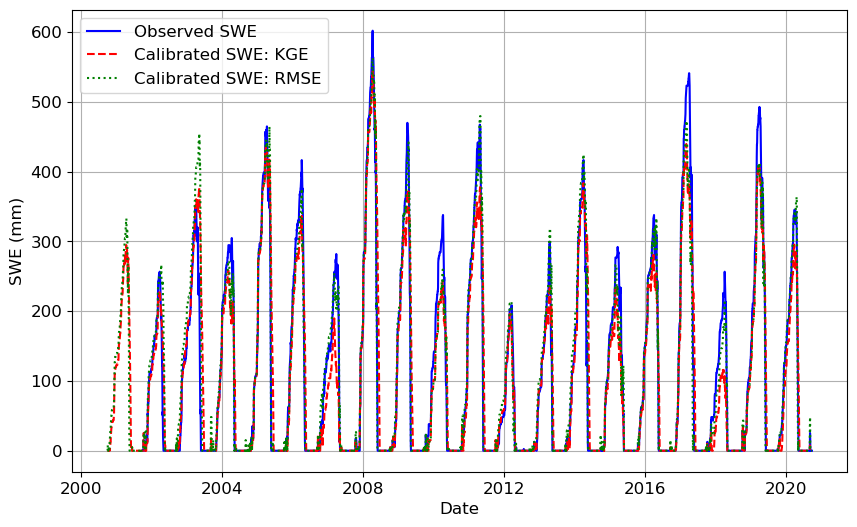

In [13]:

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10, 6))
plt.plot(t, SWE_o, label='Observed SWE', color='blue')
plt.plot(t, calibrated_SWE, label='Calibrated SWE: KGE', color='red', linestyle='--')
plt.plot(t, calibrated_SWE_rmse, label='Calibrated SWE: RMSE', color='green', linestyle=':')
plt.xlabel("Date")
plt.ylabel("SWE (mm)")
plt.legend()
plt.grid()
plt.show()

### 5.4 Create and Animation of the Optimization Path

Again, using the fact that we computed the RMSE surface from our previous sensitivity analysis notebook, let's again create an animation of how the algorithm navigated the RMSE surface in getting from the initial guess to the optimized parameters. 

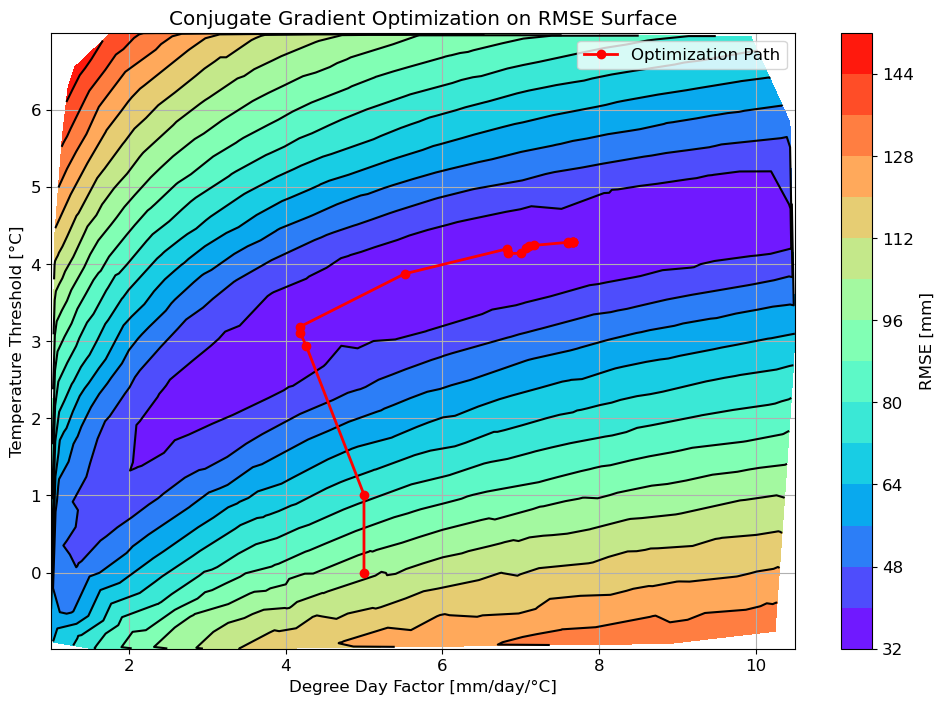

In [14]:
RMSE_sa = df_error_metric_sa['RMSE_sa'].values

# Create a figure for the animation
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the KGE surface
contour = ax.tricontour(DD_sa,Tt_sa,RMSE_sa,levels=15,colors='k')
contourf = ax.tricontourf(DD_sa,Tt_sa,RMSE_sa,levels=15,cmap='rainbow')
cbar = plt.colorbar(contourf, ax=ax)
cbar.set_label('RMSE [mm]')

# Add labels
plt.xlabel('Degree Day Factor [mm/day/°C]')
plt.ylabel('Temperature Threshold [°C]')
plt.grid('on')
ax.set_title('Conjugate Gradient Optimization on RMSE Surface')

intermediate_guesses_rmse = np.vstack((initial_guess, intermediate_guesses_rmse))

# Plot the optimization path as an animation
line, = ax.plot([], [], '-o', color='red', label='Optimization Path', lw=2)
ax.legend()

# Initialize the animation
def init():
    line.set_data([], [])
    return line,

# Update function for each frame
def update(frame):
    # Plot the path up to the current frame
    line.set_data(intermediate_guesses_rmse[:frame+1, 0], intermediate_guesses_rmse[:frame+1, 1])
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(intermediate_guesses_rmse), init_func=init, blit=True, interval=500)

# Save or display the animation
ani.save('downhill_simplex_rmse_optimization.gif', writer='pillow', fps=2)  # Save as GIF

![Conjugate Gradient Optimization on RMSE Surface](./downhill_simplex_rmse_optimization.gif)

## 6. Reflection

Note that our optimization algorithm produced different calibrated parameters depending on the objective function on which we were calibrating. This is interesting and prompts a few questions we should reflect on:

1. Qualitatively, how do the paths of the conjugate gradient algorithm differ when we optimized on KGE versus when we optimized on RMSE? Why might that be?
2. How do these differences manifest themselves in terms of predicting the time series of SWE? Is one better at peaks? Better at timing? Does one chronically under/over-estimate SWE? 
3. Which of the two scenarios do you think produces the better/more satisfactory results?
4. Do you think the answer would be sensitive to the initial guess?*
5. How do you think the answers would be different if we chose to optimize on MAE?*

*We'll explore this in the problem set